# Implementation of pixel-flipping algorithm

# POC

In [84]:
from torchvision import transforms
import torch
import numpy
from lrp import image

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  transforms.Normalize(mean, std)
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('../data/castle2.jpg')
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)
X=X[0]
print(X.shape)

torch.Size([3, 224, 224])


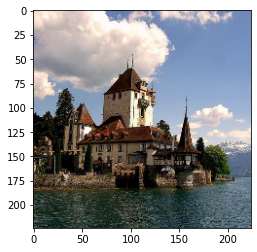

In [85]:
from matplotlib import pyplot as plt
plt.imshow(inv_normalize(X).numpy().transpose((1, 2, 0)))

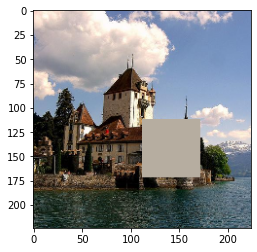

In [86]:
erased_x = transforms.functional.erase(img=X, i=112, j=112, h=60, w=60, v=1)
plt.imshow(inv_normalize(erased_x).numpy().transpose((1, 2, 0)))

# LRP

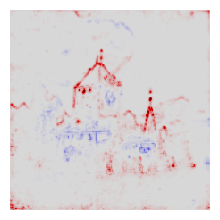

In [87]:
from typing import Callable
import torchvision
import numpy
import torch
from lrp import norm, image

from lrp.rules import LrpZBoxRule, LrpGammaRule, LrpEpsilonRule, LrpZeroRule

from typing import List, Dict, Union, Tuple
from lrp.filter import LayerFilter
from lrp.zennit.types import AvgPool, Linear
import lrp.rules as rules

from lrp.core import LRP

import lrp.plot
from matplotlib import pyplot as plt

# Normalization
# norm_fn: Callable[[torch.Tensor], torch.Tensor] = norm.ImageNetNorm()
norm_fn: Callable[[torch.Tensor], torch.Tensor] = transforms.Normalize(mean, std)

# Input data
mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]

transform = transforms.Compose([
  transforms.ToTensor(),
  transforms.Resize((224, 224)),
  transforms.ConvertImageDtype(torch.float),
  norm_fn
])

inv_normalize = transforms.Normalize(
   mean= [-m/s for m, s in zip(mean, std)],
   std= [1/s for s in std]
)

# Image is in RGB mode with range [0,1]
img: numpy.array = image.load_normalized_img('../data/castle2.jpg')
X = transform(img)
# Simulate batch by adding a new dimension
X = torch.unsqueeze(X, 0)
# X=X[0]

# Model
model = torchvision.models.vgg16(pretrained=True)
model.eval()

# Low and high parameters for zB-rule
batch_size: int = 1
shape: Tuple[int] = (batch_size, 3, 224, 224)

low: torch.Tensor = norm_fn(torch.zeros(*shape))
high: torch.Tensor = norm_fn(torch.ones(*shape))

# Init layer filter
vgg16_target_types: Tuple[type] = (Linear, AvgPool)
filter_by_layer_index_type = LayerFilter(model)
filter_by_layer_index_type.set_target_types(vgg16_target_types)

name_map: List[Tuple[List[str], rules.LrpRule, Dict[str, Union[torch.Tensor, float]]]]
name_map = [
    (filter_by_layer_index_type(lambda n: n == 0), LrpZBoxRule, {'low': low, 'high': high}),
    (filter_by_layer_index_type(lambda n: 1 <= n <= 16), LrpGammaRule, {'gamma': 0.25}),
    (filter_by_layer_index_type(lambda n: 17 <= n <= 30), LrpEpsilonRule, {'epsilon': 0.25}),
    (filter_by_layer_index_type(lambda n: 31 <= n), LrpZeroRule, {}),
]

from lrp.core import LRP

lrp = LRP(model)
lrp.convert_layers(name_map)
R: torch.Tensor = lrp.relevance(X)
lrp.heatmap(R, width=2, height=2)

# Pixel-flipping

### Sort elements

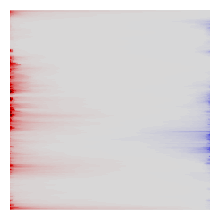

In [100]:
# Sort relevance scores by descending value
# values, indices = R.sort(dim=2, descending=True, stable=True)
values, indices = R.sort(dim=3, descending=True, stable=True)
lrp.heatmap(values, width=2, height=2)

In [89]:
b, c, h, w = values.shape

for i in range(c): 
  print('val', values[0][i][0][0])
for i in range(c): 
  print('indices ', indices[0][i][0][0])

display(torch.aminmax(R))
display(torch.aminmax(values))

val tensor(0.0002)
val tensor(0.0001)
val tensor(7.9335e-05)
indices  tensor(1)
indices  tensor(0)
indices  tensor(2)


torch.return_types.aminmax(
min=tensor(-0.0024),
max=tensor(0.0122))

torch.return_types.aminmax(
min=tensor(-0.0024),
max=tensor(0.0122))

### Finding maxima and minima in R tensor

Options:
- [`torch.amax`](https://pytorch.org/docs/stable/generated/torch.amax.html)
- [`torch.max`](https://pytorch.org/docs/stable/generated/torch.max.html#torch.max)
- [`torch.argmax`](https://pytorch.org/docs/stable/generated/torch.argmax.html)
- [`torch.aminmax`](https://pytorch.org/docs/stable/generated/torch.Tensor.aminmax.html)
- [`torch.sort`](https://pytorch.org/docs/stable/generated/torch.sort.html)
- [`torch.topk`](https://pytorch.org/docs/stable/generated/torch.topk.html#torch.topk)

In [131]:
print(r.shape)
print('aminmax',torch.aminmax(r))
print()
print('amax',torch.amax(r))
print('max',torch.max(r))
print('argmax',torch.argmax(r))

torch.Size([3, 224, 224])
aminmax torch.return_types.aminmax(
min=tensor(-0.0024),
max=tensor(0.0122))

amax tensor(0.0122)
max tensor(0.0122)
argmax tensor(72509)


## Erase k maximum elements in R tensor

In [155]:
r = R[0]
print(r.shape)
print(r[0][0][0])
print(r[1][0][0])
print(r[2][0][0])

torch.Size([3, 224, 224])
tensor(0.0001)
tensor(0.0002)
tensor(7.9335e-05)


In [162]:
r = R[0]
print(torch.amax(r))
max_r = (r==torch.max(r)).nonzero()
print(max_r.shape)
z, i, h = max_r[0].tolist()

print('max_indices', max_r[0].tolist())

max_r_val = r[z, i, h].item()
print(f'r max {max_r_val}')

tensor(0.0122)
torch.Size([1, 3])
max_indices [1, 99, 157]
r max 0.012248281389474869


### Top k elements in R

In [109]:
values, indices = torch.topk(R[0], 3)
print(torch.max(R[0]))
R[0][0][indices[0]]

tensor(0.0122)


tensor([[[ 8.2883e-04,  1.8530e-03,  1.5353e-03,  ...,  1.0258e-03,
           1.0932e-03,  6.9645e-04],
         [ 1.6630e-03,  2.0983e-03,  2.8852e-03,  ...,  9.7672e-04,
           2.0481e-03,  1.7106e-03],
         [ 4.6267e-04,  7.6435e-04,  7.8124e-04,  ...,  4.3516e-04,
           6.3110e-04,  4.2801e-04]],

        [[ 8.2883e-04,  1.8530e-03,  1.5353e-03,  ...,  1.0258e-03,
           1.0932e-03,  6.9645e-04],
         [ 1.6630e-03,  2.0983e-03,  2.8852e-03,  ...,  9.7672e-04,
           2.0481e-03,  1.7106e-03],
         [ 4.6267e-04,  7.6435e-04,  7.8124e-04,  ...,  4.3516e-04,
           6.3110e-04,  4.2801e-04]],

        [[ 3.5134e-05,  5.8759e-05,  5.0956e-05,  ...,  4.5076e-05,
           1.0492e-04,  9.3519e-05],
         [ 8.2883e-04,  1.8530e-03,  1.5353e-03,  ...,  1.0258e-03,
           1.0932e-03,  6.9645e-04],
         [ 8.2187e-05,  1.0488e-04,  9.3799e-05,  ...,  5.4513e-05,
           1.1869e-04,  1.0286e-04]],

        ...,

        [[ 1.0835e-04,  1.7757e-04,

In [90]:
R[0].shape
R.squeeze(0).shape

torch.Size([3, 224, 224])

### RGB to Grayscale Conversion

torch.Size([3, 224, 224])
torch.Size([224, 224])
first elem graysale 0.00013527712144423276


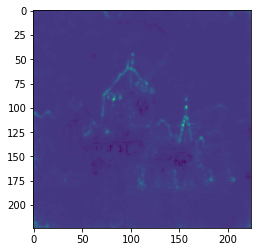

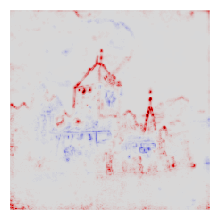

In [160]:
print(R[0].shape)
gray_r = transforms.Grayscale(num_output_channels=1)(R[0])
# gray_r = gray_r
gray_r = gray_r.squeeze()
print(gray_r.shape)
print('first elem graysale', gray_r[0][0].item())
# plt.imshow(gray_r.permute(2, 1, 0))
plt.imshow(gray_r)

from lrp.plot import heatmap
# heatmap(gray_r.permute(2,1,0), width=2, height=2)
heatmap(gray_r, width=2, height=2)

In [92]:
gray_r.aminmax()

torch.return_types.aminmax(
min=tensor(-0.0020),
max=tensor(0.0102))